In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.metrics import mean_absolute_error
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import inspect
import time

In [11]:
# Read the December 2017 and January 2018 data
dec = pd.read_csv("december_2017_sensor_data_archive.csv")
jan = pd.read_csv("january_2018_sensor_data_archive.csv")

In [12]:
# Concatenate the data into data frame
osho = pd.concat([dec, jan])
osho.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217656 entries, 0 to 153971
Data columns (total 1 columns):
 #   Column                                                             Non-Null Count   Dtype 
---  ------                                                             --------------   ----- 
 0   sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value  217656 non-null  object
dtypes: object(1)
memory usage: 3.3+ MB


In [13]:
# View the dataframe
osho.head()

sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0  7;PPD42NS;5;6.613;3.316;2017-12-12T17:30:36.50...               
1  7;PPD42NS;5;6.613;3.316;2017-12-12T17:30:36.50...               
2  7;PPD42NS;5;6.613;3.316;2017-12-12T17:30:36.50...               
3  7;PPD42NS;5;6.613;3.316;2017-12-12T17:30:36.50...               
4  7;PPD42NS;5;6.613;3.316;2017-12-12T17:30:36.50...

In [14]:
# Split the column by the semicolon delimiter
osho = osho["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"].str.split(';', expand=True)

# Assign column names to the split data
osho.columns = ['sensor_id', 'sensor_type', 'location', 'lat', 'lon', 'timestamp', 'value_type', 'value']

# Convert columns to appropriate data types
osho["sensor_id"] = pd.to_numeric(osho["sensor_id"], errors="coerce")
osho["value"] = pd.to_numeric(osho["value"], errors="coerce")

osho.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217656 entries, 0 to 153971
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    217656 non-null  int64  
 1   sensor_type  217656 non-null  object 
 2   location     217656 non-null  object 
 3   lat          217656 non-null  object 
 4   lon          217656 non-null  object 
 5   timestamp    217656 non-null  object 
 6   value_type   217656 non-null  object 
 7   value        217656 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 14.9+ MB


In [15]:
# Apply filtering
mask = osho["sensor_id"] == 7
maskVtype = osho["value_type"] == "P2"
oshoMask = osho["value"] < 500
osho = osho[mask & maskVtype & oshoMask]

# Rename the value column
osho.rename(columns={"value": "P2"}, inplace=True)

# Set timestamp as the index
osho['timestamp'] = pd.to_datetime(osho['timestamp'])
osho = osho.set_index("timestamp")

osho.head()

sensor_id sensor_type location    lat  \
timestamp                                                                 
2017-12-12 17:30:36.508047+00:00          7     PPD42NS        5  6.613   
2017-12-12 17:33:35.562072+00:00          7     PPD42NS        5  6.613   
2017-12-12 19:45:49.942087+00:00          7     PPD42NS        5  6.613   
2017-12-12 20:01:38.913138+00:00          7     PPD42NS        5  6.613   
2017-12-12 20:10:59.917129+00:00          7     PPD42NS        5  6.613   

                                    lon value_type     P2  
timestamp                                                  
2017-12-12 17:30:36.508047+00:00  3.316         P2  18.38  
2017-12-12 17:33:35.562072+00:00  3.316         P2  26.29  
2017-12-12 19:45:49.942087+00:00  3.316         P2  24.10  
2017-12-12 20:01:38.913138+00:00  3.316         P2  21.56  
2017-12-12 20:10:59.917129+00:00  3.316         P2  34.54

In [16]:
#localizing timezone
osho.index = osho.index.tz_convert("Africa/Lagos")

# Resample the timestamp
osho = osho["P2"].resample("1h").mean().ffill().to_frame()

osho.head()

P2
timestamp                           
2017-12-12 18:00:00+01:00  22.335000
2017-12-12 19:00:00+01:00  22.335000
2017-12-12 20:00:00+01:00  24.100000
2017-12-12 21:00:00+01:00  26.740769
2017-12-12 22:00:00+01:00  22.957500

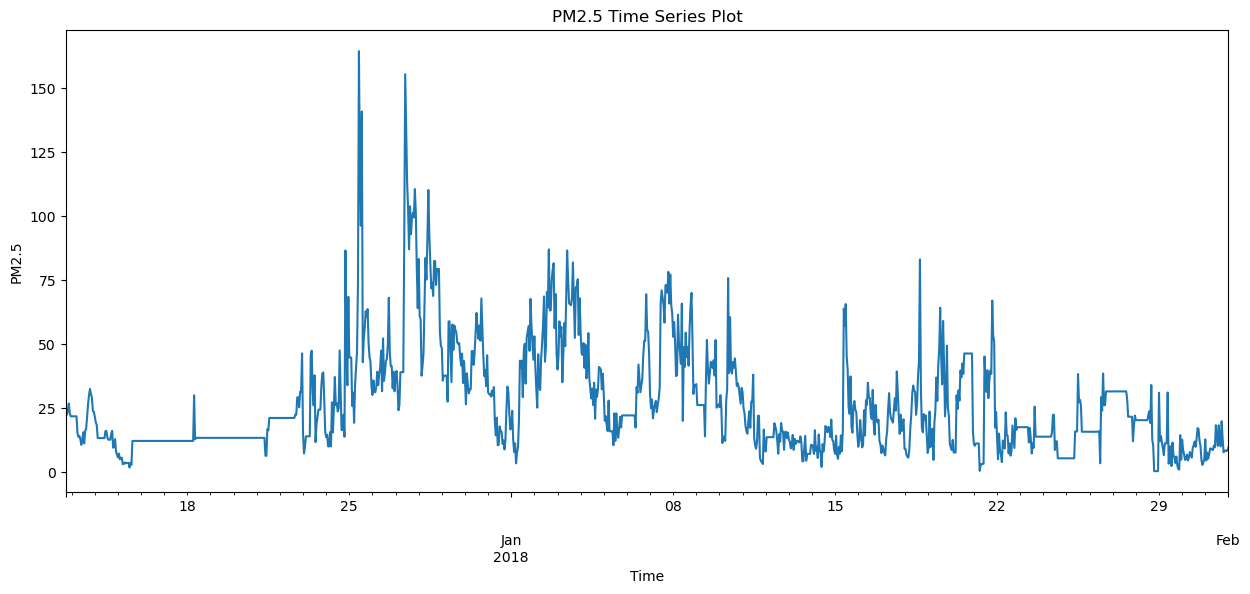

In [17]:
# Time series plot of the PM2.5 values
fig, ax = plt.subplots(figsize = (15, 6))
osho["P2"].plot(
    xlabel = "Time",
    ylabel = "PM2.5",
    title = "PM2.5 Time Series Plot",
    ax = ax
);

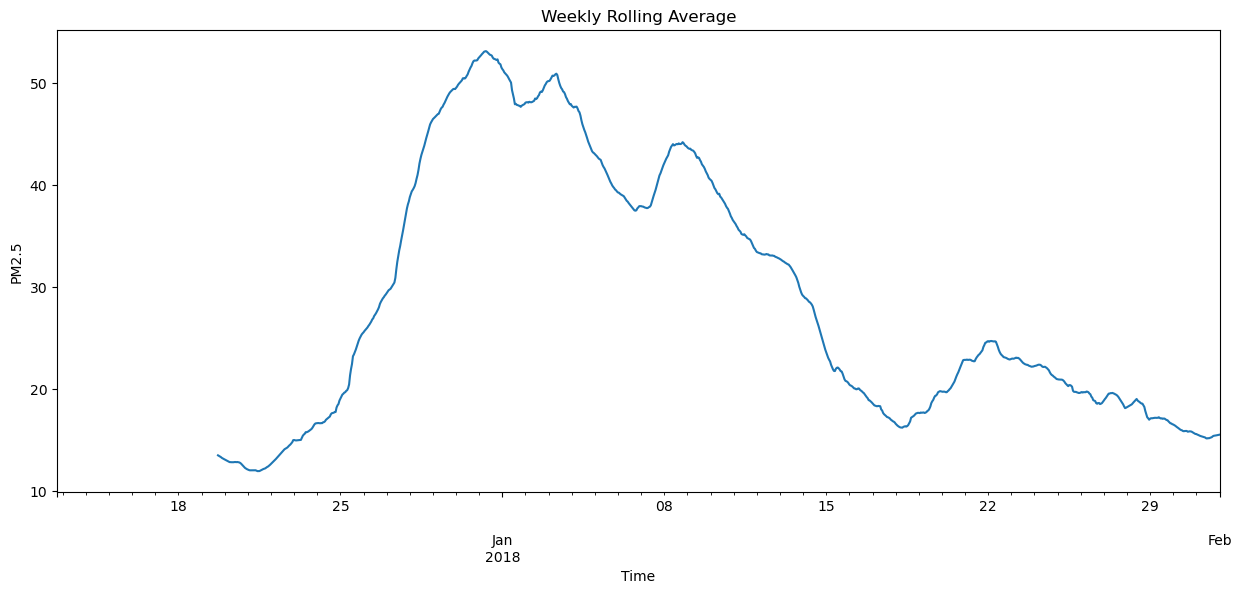

In [18]:
# 168 = number of hours per week
# Weekly rolling average plot
fig, ax = plt.subplots(figsize = (15, 6))
osho["P2"].rolling(168).mean().plot(
    xlabel = "Time",
    ylabel = "PM2.5",
    title = "Weekly Rolling Average",
    ax = ax
);

In [8]:
# Create a lag by 1 column
osho["P2.L1"] = osho["P2"].shift(1)
osho.dropna(inplace = True)

osho.head()

P2      P2.L1
timestamp                                      
2017-12-12 19:00:00+01:00  22.335000  22.335000
2017-12-12 20:00:00+01:00  24.100000  22.335000
2017-12-12 21:00:00+01:00  26.740769  24.100000
2017-12-12 22:00:00+01:00  22.957500  26.740769
2017-12-12 23:00:00+01:00  21.715600  22.957500

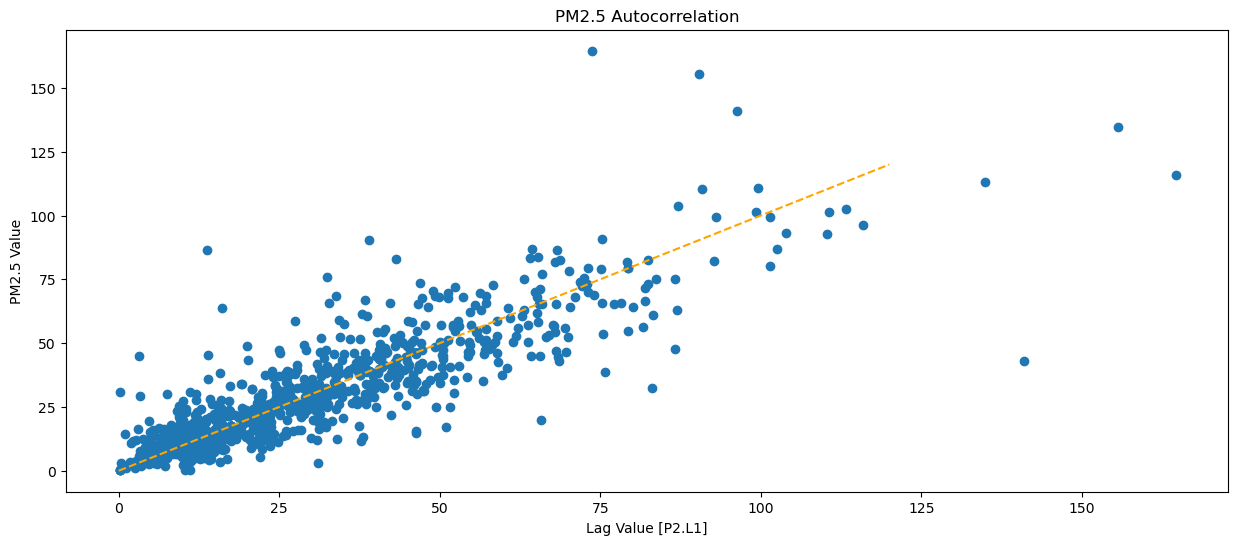

In [11]:
# Plot the correlation between the PM2.5 and PM2.5 by Lag 1 values
fig, ax = plt.subplots(figsize = (15, 6))
ax.scatter(
    x = osho["P2.L1"],
    y = osho["P2"]
)
plt.title("PM2.5 Autocorrelation")
plt.xlabel("Lag Value [P2.L1]")
plt.ylabel("PM2.5 Value")
ax.plot([0, 120], [0, 120], linestyle = "--", color = "orange");

In [9]:
# Split into training and test set
X = osho.drop(columns = "P2")
y = osho["P2"]
cutoff = int(len(X)*0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [10]:
# Train and Evaluate a Baseline Model
baseline_mae = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
baseline_mae = round(baseline_mae, 1)
print("The Benchmark of the model is:", baseline_mae)

The Benchmark of the model is: 17.0


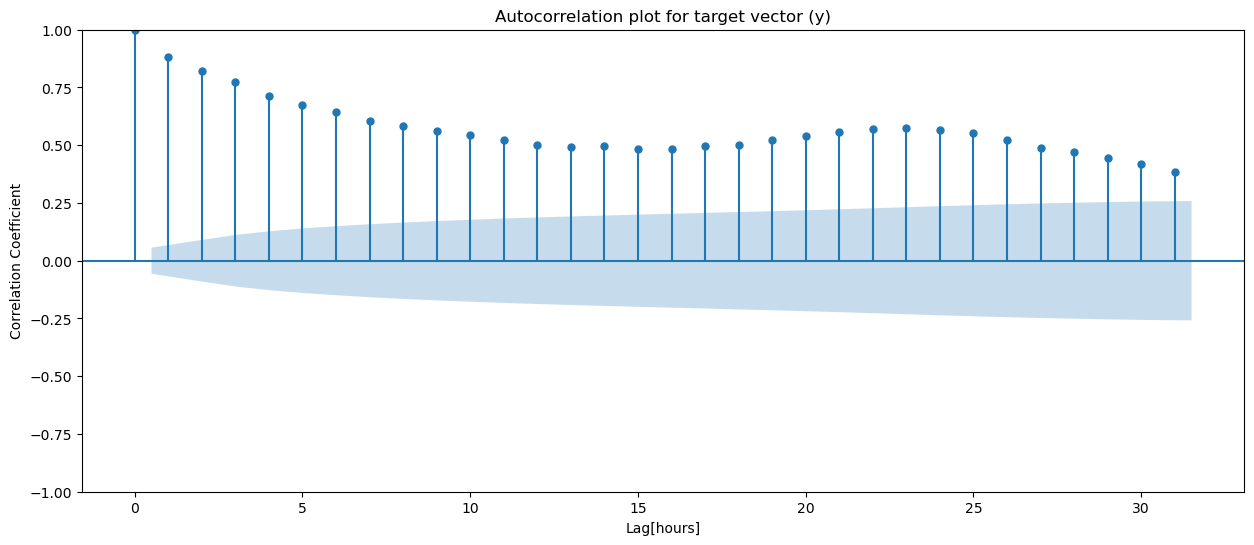

In [14]:
# Plot the ACF for the target values
fig, ax = plt.subplots(figsize = (15, 6))
plot_acf(y, ax =ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Autocorrelation plot for target vector (y)");

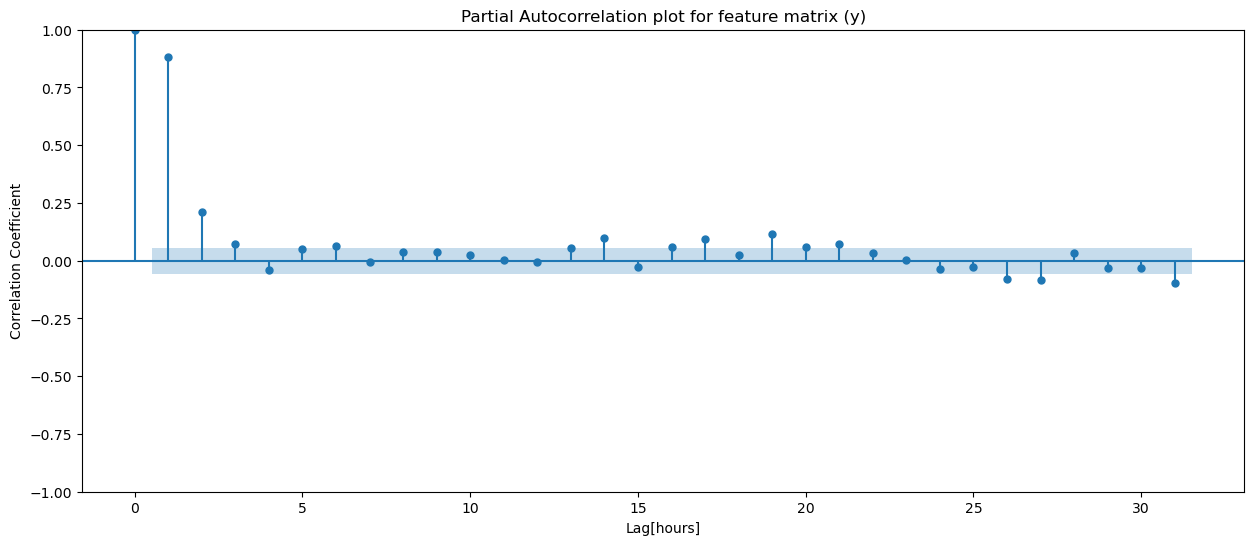

In [15]:
# Plot the PACF for the target values
fig, ax = plt.subplots(figsize = (15, 6))
plot_pacf(y, ax =ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Partial Autocorrelation plot for feature matrix (y)");

In [11]:
# Train the ARIMA model with order (p=8, d=0, q=2)
model = ARIMA(y_train, order=(8, 0, 2)).fit() #Auto Reg = 6.3
# Generate in-sample (training) predictions
y_pred = model.predict()
# Calculate training MAE
arima_mae = mean_absolute_error(y_train, y_pred)
# Append MAE to list in dictionary

print("The mean absolute error of the Autoregressive Integrated Moving Average (ARIMA) model is:", round(arima_mae, 1))
print("The Autoregressive Integrated Moving Average (ARIMA) model outperform the Baseline Model with:", round(baseline_mae - arima_mae, 1))

C:\Users\abdul\miniconda3\envs\olatronics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The mean absolute error of the Autoregressive Integrated Moving Average (ARIMA) model is: 6.2
The Autoregressive Integrated Moving Average (ARIMA) model outperform the Baseline Model with: 10.8


In [17]:
# Print out the parameters for our trained model
print(f"The parameters for our trained model are:\n{model.params}")

The parameters for our trained model are:
const      29.290967
ar.L1       1.573378
ar.L2      -0.432973
ar.L3      -0.070218
ar.L4      -0.151892
ar.L5       0.069649
ar.L6       0.061258
ar.L7      -0.113605
ar.L8       0.060724
ma.L1      -0.896754
ma.L2      -0.026175
sigma2    108.933325
dtype: float64


In [12]:
# Calculate residuals: the difference between actual and predicted values
y_train_resid = model.resid
y_train_resid[:5]

timestamp
2017-12-12 19:00:00+01:00   -6.955967
2017-12-12 20:00:00+01:00    0.896790
2017-12-12 21:00:00+01:00    2.473362
2017-12-12 22:00:00+01:00   -3.308696
2017-12-12 23:00:00+01:00   -2.567486
Freq: h, dtype: float64

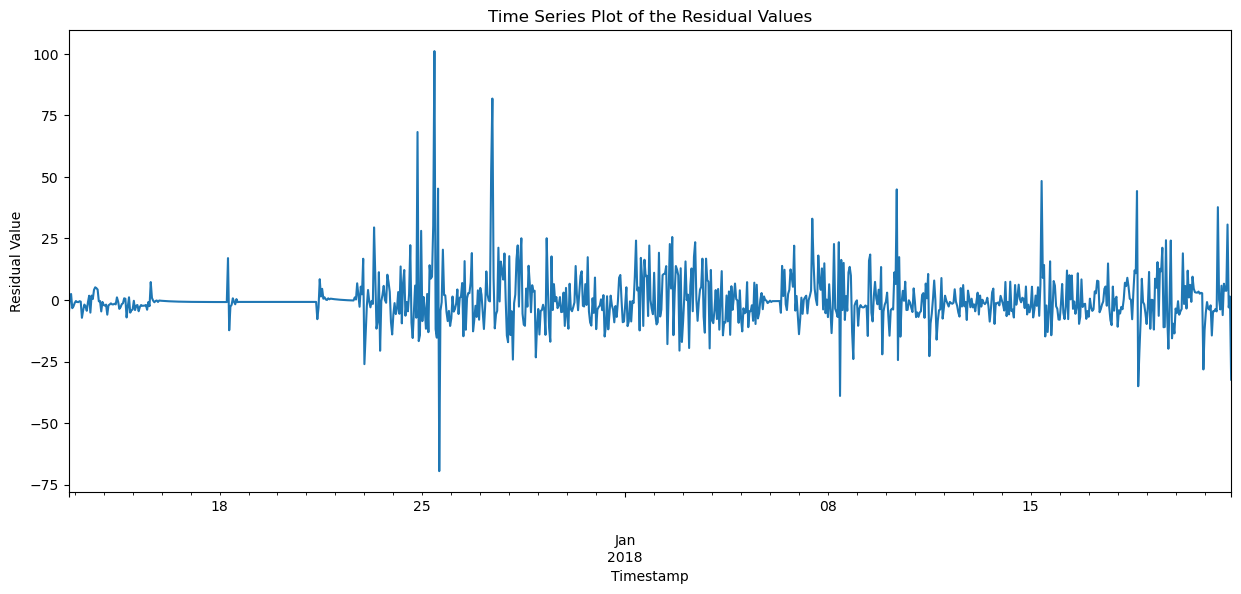

In [19]:
# Plot the residual values
fig, ax = plt.subplots(figsize = (15, 6))
y_train_resid.plot(
    xlabel = "Timestamp",
    ylabel = "Residual Value",
    title = "Time Series Plot of the Residual Values",
    ax = ax
);

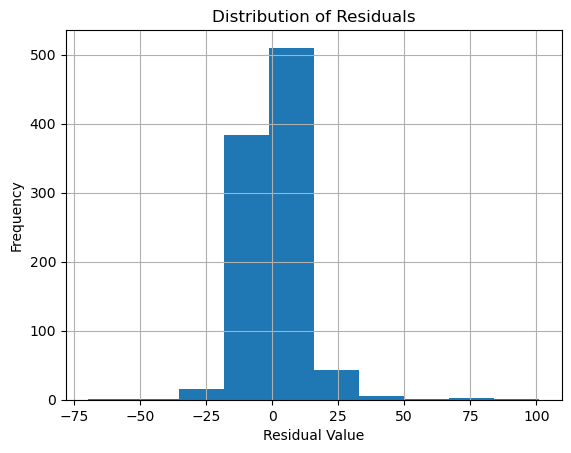

In [20]:
# Nominal Histogram of the residual values
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals");

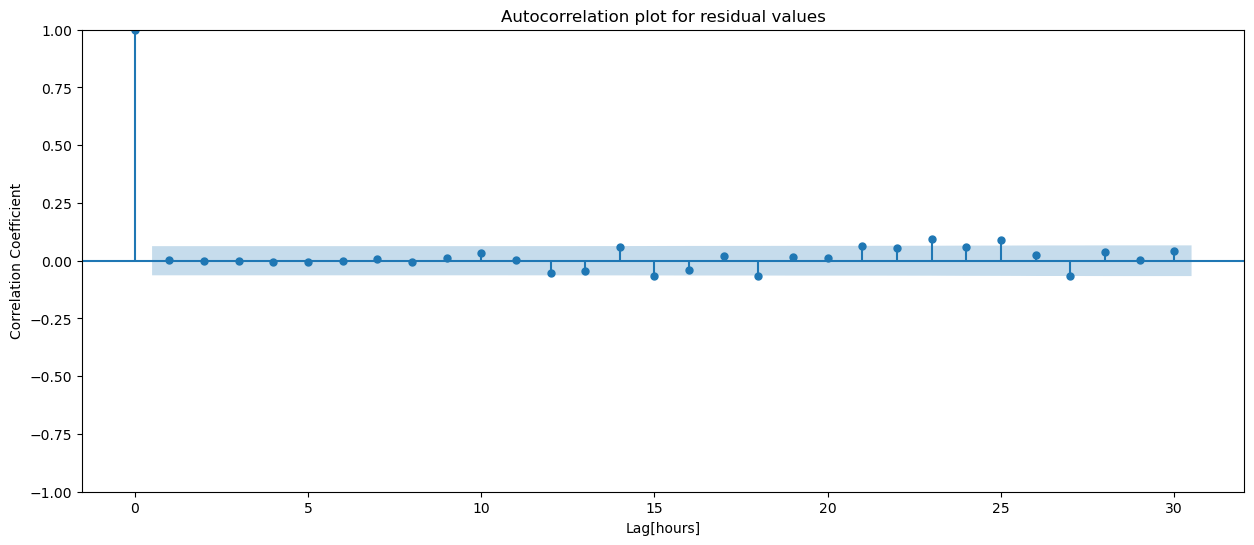

In [21]:
# ACF plot of the residual values
fig, ax = plt.subplots(figsize = (15, 6))
plot_acf(y_train_resid, ax =ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Autocorrelation plot for residual values");

In [23]:
# Making Predictions on the test set
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_pred_test, y_test)
print("The mean absolute error of our test set is:", round(test_mae, 1))

The mean absolute error of our test set is: 3.4


In [28]:
# Test set predictions dataframe using Autoregression Model
df_test_mae = pd.DataFrame(
    {
        "y_test": y_test,
        "y_test_pred": y_pred_test
    }
)
df_test_mae.head()

y_test  y_test_pred
2018-01-21 23:00:00+01:00  23.441935    25.069913
2018-01-22 00:00:00+01:00  13.340882    24.455139
2018-01-22 01:00:00+01:00   4.930000    15.049929
2018-01-22 02:00:00+01:00  14.980263    10.055375
2018-01-22 03:00:00+01:00   8.477105    13.661221

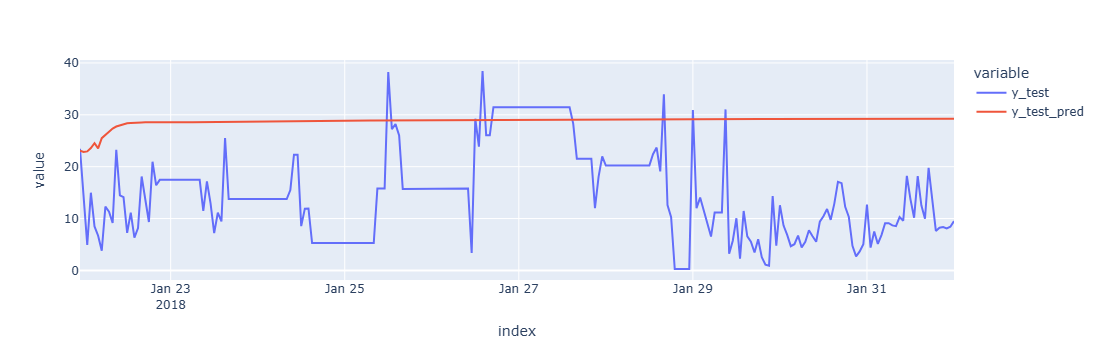

In [18]:
# Time series plot of the test set prediction
fig = px.line(
    df_test_mae,
    labels = {"Value": "P2"}
)
fig.show()

In [19]:
%%capture
# Perform a walk forward validation test prediction
wfv_test_pred = pd.Series(dtype=float)  # Initialize an empty Series with float type
past = y_train.copy()

for i in range(len(y_test)):
    model = ARIMA(past, order=(4, 0, 1)).fit()
    next_pred = model.forecast()
    next_pred = pd.Series(next_pred, index=[y_test.index[i]])
    wfv_test_pred = pd.concat([wfv_test_pred, next_pred])
    past = pd.concat([past, pd.Series(y_test.iloc[i], index=[y_test.index[i]])])  # Append new observation

In [20]:
# Calculate the mean absolute error for the list of predictions
test_mae = mean_absolute_error(y_test, wfv_test_pred)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 3.53


In [21]:
# Create a data frame for our test set and the walk-forward validation test prediction
wfv_test_df = pd.DataFrame({"y_test":y_test,
                             "wfv_test_pred":wfv_test_pred})
wfv_test_df.head()

y_test  wfv_test_pred
2018-01-21 23:00:00+01:00  23.441935      24.904667
2018-01-22 00:00:00+01:00  13.340882      24.924232
2018-01-22 01:00:00+01:00   4.930000      15.315152
2018-01-22 02:00:00+01:00  14.980263      10.311038
2018-01-22 03:00:00+01:00   8.477105      14.171670

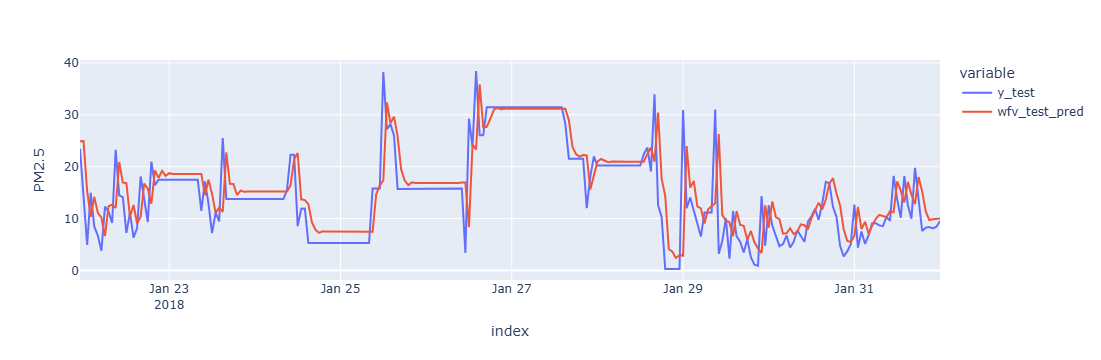

In [27]:
fig = px.line(wfv_test_df, labels={"value": "PM2.5"})
fig.show()

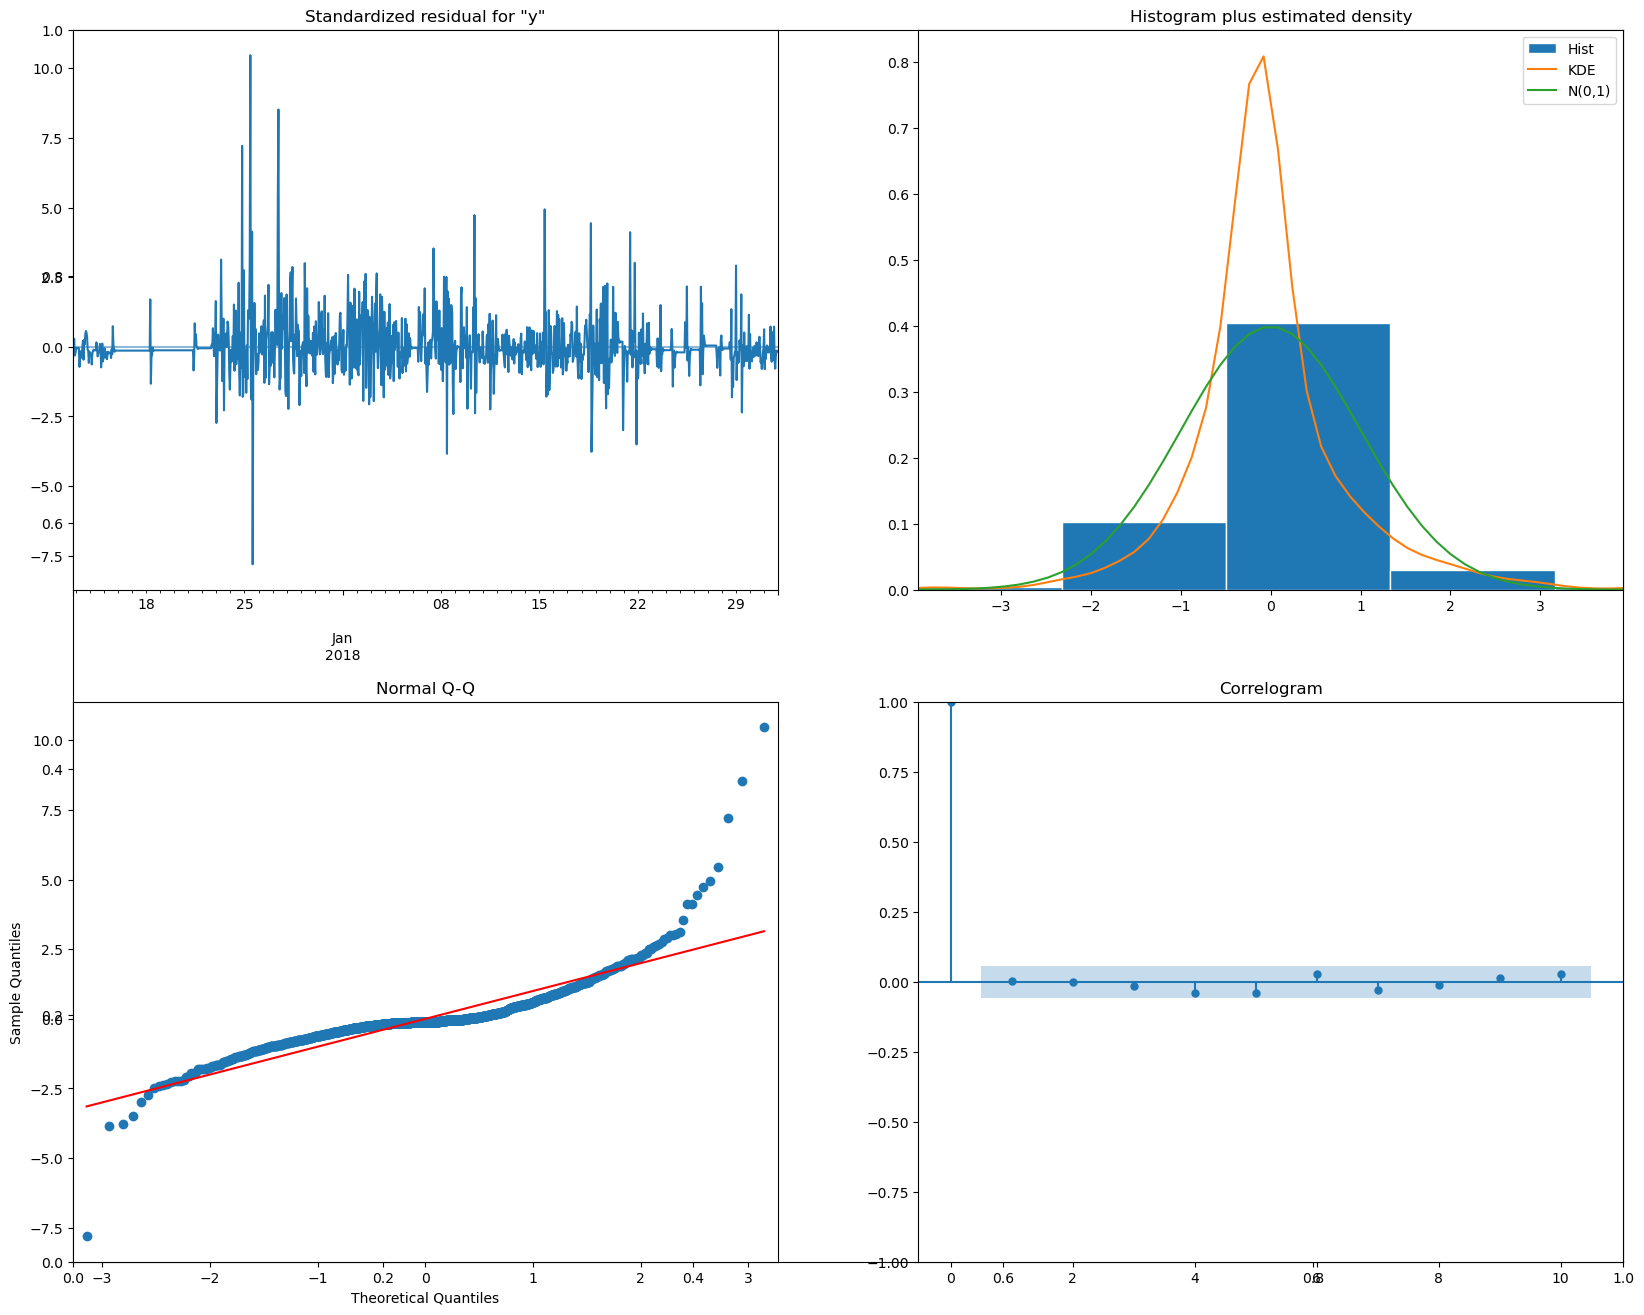

In [24]:
# Plot diagnostic to check the residuals of our model
fig, ax = plt.subplots(figsize=(20, 16))
model.plot_diagnostics(fig = fig);